# 간단한 오디오 인식 튜토리얼
이 튜토리얼은 10 개의 다른 단어를 인식하는 기본 음성 인식 네트워크를 구축하는 방법을 보여줍니다.</br>
 실제 음성 및 오디오 인식 시스템은 훨씬 더 복잡하지만 이미지 용 MNIST와 마찬가지로 관련된 기술에 대한 기본적인 이해를 제공해야 합니다</br>
 이 자습서를 완료하면 1초 오디오 클립을 "아래", "이동", "왼쪽", "아니요", "중지", "위"로 분류하는 모델이 생성됩니다.

## 설정
필요한 모듈 및 종속성을 가져옵니다.

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Speech Commands 데이터 세트 
Speech Commands 데이터 세트 의 일부를 다운로드하는 스크립트를 작성합니다.</br> 원래 데이터 세트는 30 개의 다른 단어를 말하는 사람들의 105,000 개 이상의 WAV 오디오 파일로 구성됩니다.</br> 이 데이터는 Google에서 수집하고 CC BY 라이선스에 따라 공개되었습니다.

데이터로드 시간을 절약하기 위해 데이터 세트의 일부를 사용하게 됩니다.</br> mini_speech_commands.zip unzip하고 tf.data API를 로드

In [3]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 1s 0us/step


데이터 세트에 대한 기본 통계를 확인합니다.


In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['no' 'right' 'stop' 'go' 'down' 'up' 'yes' 'left']


오디오 파일을 목록으로 추출하고 섞습니다.

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/up/b3bdded5_nohash_0.wav', shape=(), dtype=string)


각각 80:10:10 비율을 사용하여 파일을 학습, 검증 및 테스트 세트로 분할합니다.

In [6]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## 오디오 파일 및 레이블 읽기
오디오 파일은 처음에는 이진 파일로 읽혀지며 숫자 텐서로 변환 할 수 있습니다.
</br></br>
오디오파일을 로드하려면 WAV 인코딩 오디오를 Tensor 및 샘플 속도로 반환하는 tf.audio.decode_wav 를 사용합니다.
</br></br>
WAV 파일에는 초당 샘플 수가 설정된 시계열 데이터가 포함됩니다.
각 샘플은 특정 시간에 오디오 신호의 진폭을 나타냅니다.</br>
mini_speech_commands 의 파일과 같이 16 비트 시스템에서 값의 범위는 -32768에서 32767입니다.</br>
 이 데이터 세트의 샘플 속도는 16kHz입니다. tf.audio.decode_wev 는 값을 [-1.0, 1.0] 범위로 정규화합니다.


In [7]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

 각 WAV 파일의 레이블은 상위 디렉토리입니다.

In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    return parts[-2]

WAV 파일의 파일 이름을 가져와 감독 교육을 위한 오디오 및 레이블이 포함 된 튜플을 출력하는 방법을 정의 해 보겠습니다.

In [9]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

 이제 process_path 를 적용하여 오디오 레이블 쌍을 추출하고 결과를 확인하는 훈련 세트를 빌드합니다.</br>
  나중에 유사한 절차를 사용하여 유효성 검사 및 테스트 세트를 빌드합니다.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

해당 레이블이 있는 몇가지 오디오 파형을 살펴 보겠습니다.

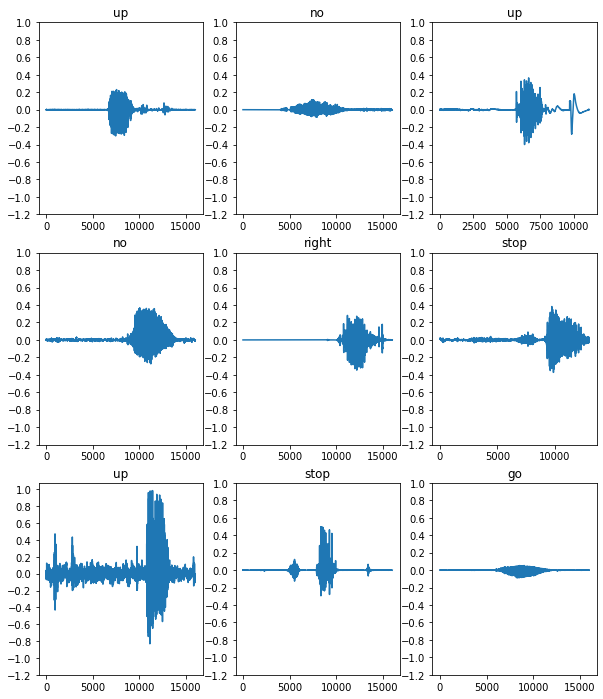

In [11]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

## 스펙트로 그램
파형을 스펙트로 그램으로 변환하여 시간에 따른 주파수 변화를 보여주고 2D 이미지로 표현할 수 있습니다.</br>
이는 단시간 푸리에 변환 (STFT)을 적용하여 오디오를 시간-주파수 도메인으로 변환함으로써 수행 할 수 있습니다.</br>
푸리에 변환 ( tf.signal.fft )은 신호를 구성 주파수로 변환하지만 모든 시간 정보를 잃습니다.</br>
 STFT ( tf.signal.stft )는 신호를 시간 창으로 분할하고 각 창에서 푸리에 변환을 실행하여 일부 시간 정보를 보존하고 표준 컨볼 루션을 실행할 수있는 2D 텐서를 반환합니다.</br>
</br>
STFT는 크기와 위상을 나타내는 복소수의 배열을 생성합니다. 그러나 tf.abs 의 출력에 tf.signal.stft 적용하여 파생 될 수있는이 자습서의 크기 만 필요합니다.</br>
</br>
생성 된 스펙트로 그램 "이미지"가 거의 정사각형이되도록 frame_length 및 frame_step 매개 변수를 선택합니다. STFT 매개 변수 선택에 대한 자세한 내용은 오디오 신호 처리에 대한 이 비디오 를 참조하십시오.</br>
</br>
또한 파형의 길이가 같으면 스펙트로 그램 이미지로 변환 할 때 결과가 비슷한 치수를 갖게됩니다. 이것은 1 초보다 짧은 오디오 클립을 0으로 채우기 만하면됩니다.

In [13]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
 
    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)

    spectrogram = tf.abs(spectrogram)

    return spectrogram

다음으로 데이터를 탐색합니다. 파형, 스펙트로 그램 및 데이터 세트에서 한 예의 실제 오디오를 비교합니다.

In [14]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label', label)
print('Waveform shape', waveform.shape)
print('Spectrogram shape', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label up
Waveform shape (16000,)
Spectrogram shape (124, 129)
Audio playback


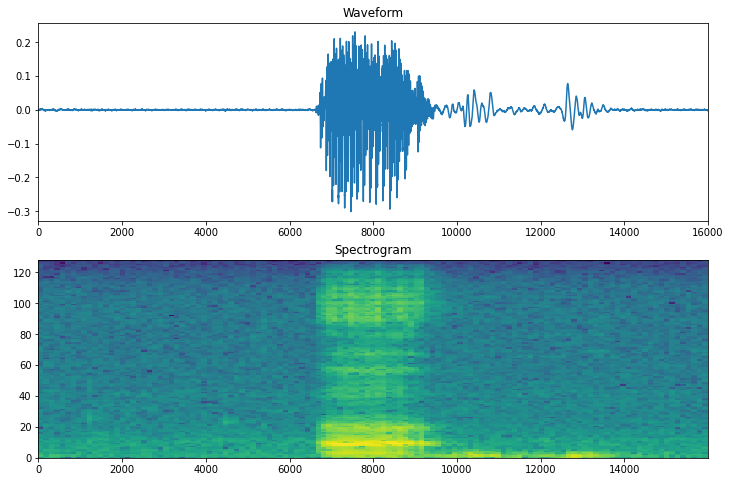

In [15]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

이제 스펙트로 그램 이미지와 해당 레이블을 정수 ID로 갖도록 파형 데이터 세트를 변환하십시오.

In [16]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [17]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

데이터 세트의 다른 샘플에 대한 스펙트럼 그램 "이미지"를 조사합니다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


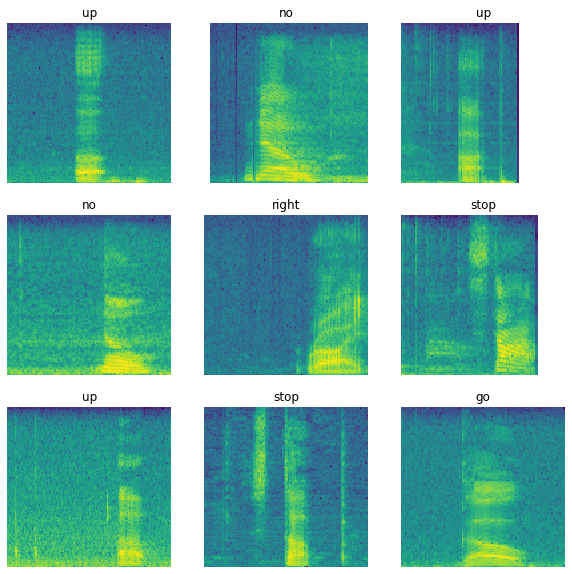

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## 모델 구축 및 훈련
이제 모델을 구축하고 훈련 할 수 있습니다.</br> 그러나 그렇게하기 전에 검증 및 테스트 세트에 대해 학습 세트 전처리를 반복해야합니다.

In [19]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

In [20]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

모델 학습을위한 학습 및 검증 세트를 일괄 처리합니다.

In [21]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

모델을 학습하는 동안 읽기 지연 시간을 줄이기 위해 데이터 세트 cache() 및 prefetch() 작업을 추가합니다.

In [22]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

모델의 경우 오이도 파일을 스펙트로 그램 이미지로 변환 했으므로 간단한 CNN (Convolution Neural Network)을 사용합니다.</br>
모델에는 다음과 같은 추가 전처리 레이어도 있습니다.
- 모델이 더 빠르게 학습 할 수 있도록 입력을 다운 샘플링하는 Resizing 레이어입니다.
- 평균 및 표준 편차를 기반으로 이미지의 각 픽셀로 정규화 하는 Normalization 레이어입니다.

Normalization 계층의 경우 집계 통계 (즉, 평균 및 표준 편차)를 계산하기 위해 먼저 훈련 데이터에서 adapt 메서드를 호출해야 합니다.

In [25]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [29]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 16s 162ms/step - loss: 1.7405 - accuracy: 0.3797 - val_loss: 1.3015 - val_accuracy: 0.5962
Epoch 2/10
100/100 [==============================] - 1s 7ms/step - loss: 1.1870 - accuracy: 0.5848 - val_loss: 1.0025 - val_accuracy: 0.7013
Epoch 3/10
100/100 [==============================] - 1s 6ms/step - loss: 0.9009 - accuracy: 0.6831 - val_loss: 0.7711 - val_accuracy: 0.7538
Epoch 4/10
100/100 [==============================] - 1s 7ms/step - loss: 0.7526 - accuracy: 0.7289 - val_loss: 0.6947 - val_accuracy: 0.7738
Epoch 5/10
100/100 [==============================] - 1s 7ms/step - loss: 0.6586 - accuracy: 0.7664 - val_loss: 0.6640 - val_accuracy: 0.7763
Epoch 6/10
100/100 [==============================] - 1s 7ms/step - loss: 0.5974 - accuracy: 0.7862 - val_loss: 0.5863 - val_accuracy: 0.8037
Epoch 7/10
100/100 [==============================] - 1s 7ms/step - loss: 0.5115 - accuracy: 0.8238 - val_loss: 0.5486 - val_accuracy: 0.8175
Epo

학습 및 검증 손실 곡선을 확인하여 학습 중에 모델이 어떻게 개선되었는지 살펴 보겠습니다.

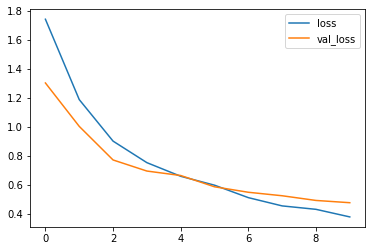

In [34]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## 테스트 세트 성능 평가
테스트 세트에서 모델을 실행하고 성능을 확인합시다.

In [36]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [40]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 86%


### 혼동 행렬 표시
혼동 행렬은 테스트 세트의 각 명령에서 모델이 얼마나 잘 수행했는지 확인하는 데 유용합니다.

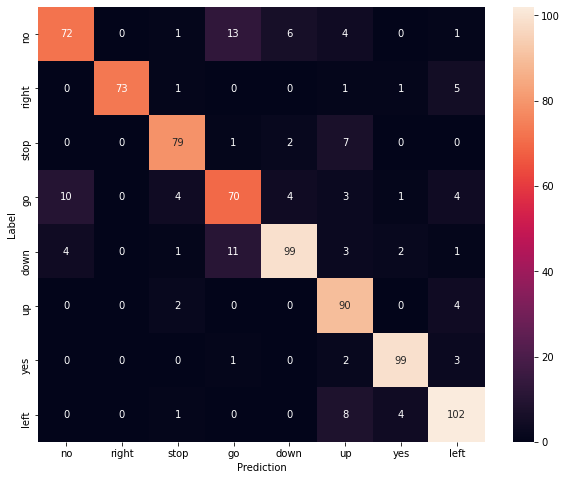

In [41]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### 오디오 파일에서 추론 실행
마지막으로 "아니오"라고 말하는 사람의 입력 오디오 파일을 사용하여 모델의 예측 출력을 확인합니다.

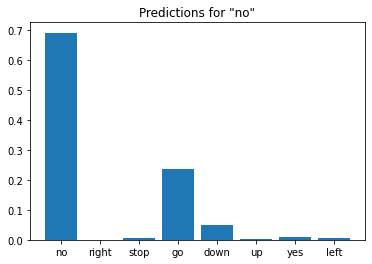

In [42]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

모델이 오디오 명령을 "아니요로 매우 명확하게 인식했음을 알 수 있습니다.